In [1]:
import json
import os
import sys
import math
import datetime
import pathlib
import numpy as np

dir_path = pathlib.Path(os.path.abspath('')).resolve()
print(dir_path)
HOME_DIR = str(dir_path).split('/OpenFormat-Public')[0]

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

PROJ_SRC_DIR = f'{HOME_DIR}/OpenFormat-Public'
sys.path.insert(1, f'{PROJ_SRC_DIR}')
from python.scripts.utils import *
num_rows = 1000 * 1000
num_cols = 20
workload_list = ['core', 'geo', 'classic', 'log', 'ml', 'bi']

/home/haoyuq/EvaluationOfColumnarFormats/OpenFormat/OpenFormat-Public/python/general


In [2]:
HOME_DIR = str(dir_path).split('/OpenFormat')[0]
scan_exec_pq = f'{HOME_DIR}/arrow-private/arrow-Public/cpp/out/build/openformat-release-static/release/parquet-scan-columnbatch'

# Predefined workloads, size and scan time

In [3]:
%%time
# generate csv files
os.chdir(f'{PROJ_SRC_DIR}/benchmark/generator_v2')
!pwd
for wl in workload_list:
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    os.system(f'python3 gen_workloads.py \
        {wl} {num_rows} {num_cols} {base_name}')
    os.system(f'cp -r {base_name} {dir_path} && \
        rm -r {base_name}')
os.chdir(dir_path)
!pwd

/home/haoyuq/EvaluationOfColumnarFormats/OpenFormat/OpenFormat-Public/benchmark/generator_v2
Finish core dataset! 🎉🎉🎉🎉🎉🎉
Generating Done!!
Finish workload: geo! 🎉🎉🎉🎉🎉🎉
Generating Done!!
Finish workload: classic! 🎉🎉🎉🎉🎉🎉
Generating Done!!
🤔 INFO: too many collisions in int_unique_list, 19734 values just use (max_value + 1)!
🤔 INFO: too many collisions in int_unique_list, 342213 values just use (max_value + 1)!
Finish workload: log! 🎉🎉🎉🎉🎉🎉
Generating Done!!
Finish workload: ml! 🎉🎉🎉🎉🎉🎉
Generating Done!!
🤔 INFO: too many collisions in int_unique_list, 7 values just use (max_value + 1)!
Finish workload: bi! 🎉🎉🎉🎉🎉🎉
Generating Done!!
/home/haoyuq/EvaluationOfColumnarFormats/OpenFormat/OpenFormat-Public/python/general
CPU times: user 28.9 ms, sys: 19.1 ms, total: 48 ms
Wall time: 12min 19s


In [3]:
pq_config = enumerate_config(f'{PROJ_SRC_DIR}/python/experiments/pq_default.json')
orc_config = enumerate_config(f'{PROJ_SRC_DIR}/python/experiments/orc_default.json')
pq_name_suffix = '_' + "_".join([str(i) for i in list(pq_config[0].values())]) + '.parquet'
orc_name_suffix = '_' + "_".join([str(i) for i in list(orc_config[0].values())]) + '.orc'
print(pq_name_suffix)
print(orc_name_suffix)
print(pq_config)
print(orc_config)

loading config from /home/haoyuq/EvaluationOfColumnarFormats/OpenFormat/OpenFormat-Public/python/experiments/pq_default.json ...
loading config from /home/haoyuq/EvaluationOfColumnarFormats/OpenFormat/OpenFormat-Public/python/experiments/orc_default.json ...
_SNAPPY_True_1048576_1048576_2.6_2.0.parquet
_SNAPPY_speed_0.8.orc
[{'compression': 'SNAPPY', 'use_dictionary': True, 'dictionary_pagesize_limit': 1048576, 'row_group_size': 1048576, 'version': '2.6', 'data_page_version': '2.0'}]
[{'compression': 'SNAPPY', 'compression_strategy': 'speed', 'dictionary_key_size_threshold': 0.8}]


## BtrBlocks files

In [5]:
# create btrblock schema file
import yaml
os.chdir(f'{PROJ_SRC_DIR}/python')
for wl in workload_list:
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    arrow_schema_name = f'general/{base_name}/gen_data/{base_name}_arrow_schema.txt'
    with open(arrow_schema_name, 'r') as f:
        lines = f.readlines()
    columns = []
    cnt = 0
    for line in lines:
        if 'message' in line or '}' in line or len(line)==0:
            print(line)
            continue
        col_name = f'col{cnt}'
        col_type = None
        if 'String' in line:
            col_type = 'string'
        elif 'int' in line:
            col_type = 'integer'
        elif 'double' in line:
            col_type = 'double'
        if col_type is None:
            print(line)
            col_type = 'skip'
        cnt += 1
        columns.append({'name': col_name, 'type':col_type})
    with open(f'general/{base_name}/gen_data/{base_name}_btrblocks_schema.yaml','w') as f:
        yaml.dump({'columns':columns}, f)

message schema {

}
message schema {

}
message schema {

}
message schema {

}
message schema {

}
message schema {

}


In [46]:
os.chdir(f'{PROJ_SRC_DIR}/python')
my_password = ""
for wl in workload_list:
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    print(base_name)
    os.system(f'cp general/{base_name}/gen_data/{base_name}.csv data_gen')
    os.system(f'echo {my_password} | sudo -S /home/haoyuq/miniconda3/envs/gen/bin/python scripts/parquet_exp.py {base_name} pq_plain -r=false -o=false')
    os.system(f'echo {my_password} | sudo -S /home/haoyuq/miniconda3/envs/gen/bin/python scripts/orc_exp.py {base_name} orc_plain -r=false -o=false')
    os.system(f'mv {base_name}{pq_name_suffix} general/{base_name}{pq_name_suffix}.parquet')
    os.system(f'mv {base_name}{orc_name_suffix} general/{base_name}{orc_name_suffix}.orc')
os.chdir(f'{PROJ_SRC_DIR}/python/general')

core_r1000000_c20


[sudo] password for haoyuq: 

loading config from ./experiments/pq_plain.json ...
----Running experiment: 1 out of 1----
NONE_False_1048576_2.6_2.0
write parquet time (s): 0.47096872329711914


[sudo] password for haoyuq: 

loading config from ./experiments/orc_plain.json ...
----Running experiment:----
UNCOMPRESSED_speed_0
write orc time (s): 0.7955284118652344
geo_r1000000_c20


[sudo] password for haoyuq: 

loading config from ./experiments/pq_plain.json ...
----Running experiment: 1 out of 1----
NONE_False_1048576_2.6_2.0
write parquet time (s): 0.5635099411010742


[sudo] password for haoyuq: 

loading config from ./experiments/orc_plain.json ...
----Running experiment:----
UNCOMPRESSED_speed_0
write orc time (s): 0.9063608646392822
classic_r1000000_c20


[sudo] password for haoyuq: 

loading config from ./experiments/pq_plain.json ...
----Running experiment: 1 out of 1----
NONE_False_1048576_2.6_2.0
write parquet time (s): 0.6187753677368164


[sudo] password for haoyuq: 

loading config from ./experiments/orc_plain.json ...
----Running experiment:----
UNCOMPRESSED_speed_0
write orc time (s): 1.0068562030792236
log_r1000000_c20


[sudo] password for haoyuq: 

loading config from ./experiments/pq_plain.json ...
----Running experiment: 1 out of 1----
NONE_False_1048576_2.6_2.0
write parquet time (s): 0.5352048873901367


[sudo] password for haoyuq: 

loading config from ./experiments/orc_plain.json ...
----Running experiment:----
UNCOMPRESSED_speed_0
write orc time (s): 0.8383834362030029
ml_r1000000_c20


[sudo] password for haoyuq: 

loading config from ./experiments/pq_plain.json ...
----Running experiment: 1 out of 1----
NONE_False_1048576_2.6_2.0
write parquet time (s): 0.5402238368988037


[sudo] password for haoyuq: 

loading config from ./experiments/orc_plain.json ...
----Running experiment:----
UNCOMPRESSED_speed_0
write orc time (s): 0.955223560333252
bi_r1000000_c20


[sudo] password for haoyuq: 

loading config from ./experiments/pq_plain.json ...
----Running experiment: 1 out of 1----
NONE_False_1048576_2.6_2.0
write parquet time (s): 0.4400486946105957


[sudo] password for haoyuq: 

loading config from ./experiments/orc_plain.json ...
----Running experiment:----
UNCOMPRESSED_speed_0
write orc time (s): 0.7259507179260254


In [4]:
run_list = [3, 4,5,6,7,8, 9,10]

In [ ]:
# generating files for btrblocks
os.chdir(f'{PROJ_SRC_DIR}/python')
prev = 2
my_password = "Woshimima2@"
for run in run_list:
    old_text = 'rle_run_length_threshold{' + str(prev) + '}'
    new_text = 'rle_run_length_threshold{' + str(run) + '}'
    os.system(f"sed -i s'/{old_text}/{new_text}/g' /home/haoyuq/btrblocks/btrblocks/scheme/SchemeConfig.hpp")
    prev = run
    # rebuild
    os.chdir("/home/haoyuq/btrblocks/build")
    os.system("make")
    os.chdir(f'{PROJ_SRC_DIR}/python')
    os.system(f"mkdir general/btrmeta_run_{run}")
    name = f"btrmeta_run_{run}"
    for wl in workload_list:
        os.chdir(f"{PROJ_SRC_DIR}/python")
        base_name = f'{wl}_r{num_rows}_c{num_cols}'
        os.system(f'mkdir general/{base_name}/gen_data/run_{run}')
        os.system(f'mkdir general/{base_name}/gen_data/run_{run}/binary')
        os.system(f'mkdir general/{base_name}/gen_data/run_{run}/btr')
        
        os.system(f'~/btrblocks/build/csvtobtr -create_binary -binary general/{base_name}/gen_data/run_{run}/binary/ -csv general/{base_name}/gen_data/{base_name}.csv -yaml general/{base_name}/gen_data/{base_name}_btrblocks_schema.yaml')
        os.system(f'~/btrblocks/build/csvtobtr -create_btr -btr general/{base_name}/gen_data/run_{run}/btr/ -binary general/{base_name}/gen_data/run_{run}/binary/ -csv general/{base_name}/gen_data/{base_name}.csv -yaml general/{base_name}/gen_data/{base_name}_btrblocks_schema.yaml')
        os.system(f'~/btrblocks/build/btrmeta -btr general/{base_name}/gen_data/run_{run}/btr/ >> general/{name}/{base_name}_trace.txt')

        os.chdir(f"{PROJ_SRC_DIR}/python/general")
        os.system(f'echo {my_password} | sudo -S sync; echo {my_password} | sudo sh -c "/usr/bin/echo 3 > /proc/sys/vm/drop_caches"')
        time.sleep(1)
        pq_read = float(os.popen(f'''{scan_exec_pq} \
                --batch_size=1024 ./{base_name}.parquet''').read().split('\n')[0].split(' ')[-2])
        os.system(f'echo {my_password} | sudo -S sync; echo {my_password} | sudo sh -c "/usr/bin/echo 3 > /proc/sys/vm/drop_caches"')
        time.sleep(1)
        orc_read = float(os.popen(f'''{HOME_DIR}/orc/orc/build/tools/src/orc-scan \
                -b 1024 ./{base_name}.orc''').read().split('\n')[0].split(' ')[-1])
        os.system(f'echo {my_password} | sudo -S sync; echo {my_password} | sudo sh -c "/usr/bin/echo 3 > /proc/sys/vm/drop_caches"')
        time.sleep(1)
        btrblocks_out = os.popen(f'''~/btrblocks/build/decompression-speed -output_summary \
                    -btr ./{base_name}/gen_data/run_{run}/btr/ -threads 1''').read()
        with open(f'{name}/{base_name}_res.txt', 'w') as f:
            f.write(btrblocks_out)
        btrblocks_out = btrblocks_out.split('\n')[-2]
        print(btrblocks_out)
        btrblocks_read = float(btrblocks_out.split(' ')[-4])
        btrblocks_size = float(btrblocks_out.split(' ')[1])
        print(btrblocks_size)
        btrblocks_size_with_metadata = btrblocks_size + os.path.getsize(f'./{base_name}/gen_data/run_{run}/btr/metadata')
        orc_size = os.path.getsize(f'{base_name}.orc')
        pq_size = os.path.getsize(f'{base_name}.parquet')
        output_stats = {}
        output_stats['workload'] = wl
        output_stats['run'] = run
        output_stats['file'] = 'parquet'
        output_stats['size'] = pq_size
        output_stats['read_time'] = pq_read
        parse_output(output_stats)
        output_stats['file'] = 'orc'
        output_stats['size'] = orc_size
        output_stats['read_time'] = orc_read
        parse_output(output_stats)
        output_stats['file'] = 'btrblocks'
        output_stats['size'] = btrblocks_size
        output_stats['read_time'] = btrblocks_read
        output_stats['size_with_metadata'] = btrblocks_size_with_metadata
        parse_output(output_stats)
collect_results()
os.system('mv outputs/stats.csv ../outputs/{}_{}.csv'.format('varying_rle', timestamp))
os.chdir(f'{PROJ_SRC_DIR}/python/general')

[  3%] Built target fastpfor_src
[  6%] Built target fsst_src
[  9%] Built target croaring_src
[ 13%] Built target tbb_src
[ 16%] Built target gflags_src
[ 20%] Built target spdlog_src
[ 24%] Built target yaml_src
[ 24%] Performing update step for 'csv_src'
[ 25%] No patch step for 'csv_src'
[ 26%] Performing configure step for 'csv_src'


CMake Warning (dev) at CMakeLists.txt:1 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.



-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/haoyuq/btrblocks/build/vendor/csv-parser/src/csv_src-build
[ 26%] Performing build step for 'csv_src'
[ 26%] Performing install step for 'csv_src'
Install the project...
-- Install configuration: ""
-- Installing: /home/haoyuq/btrblocks/build/vendor/csv-parser/include/parser.hpp
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserTargets.cmake
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserConfig.cmake
[ 26%] Performing copy_parser step for 'csv_src'
[ 27%] Completed 'csv_src'
[ 28%] Built target csv_src
[ 31%] Built target googletest
[ 35%] Built target gtest_src
[ 39%] Built target gmock_src
[ 43%] Built target libawscpp-download
[ 47%] Built target benchmark_src
[ 51%] Built target gdouble_src
[ 55%] Built target turbo_src
[ 59%] Built target lz4_src
[ 59%] Building CXX object CMakeFiles/btr

/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = double; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:180:11: warning: unused variable ‘cache’ [-Wunused-variable]
  180 |     auto& cache = ThreadCache::get();
      |           ^~~~~
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = int; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cp

[ 95%] Linking CXX executable sampling_algorithms
[ 95%] Built target sampling_algorithms
[ 95%] Building CXX object CMakeFiles/threadlocal_config.dir/tools/playground/config.cpp.o
[ 95%] Linking CXX executable threadlocal_config
[ 95%] Built target threadlocal_config
[ 96%] Built target test-s3
[ 97%] Built target test-s3-crt
[ 98%] Built target test-s3-custom-stream
[ 98%] Built target test-s3-transfer
[ 99%] Built target generate_s3_data
[ 99%] Building CXX object CMakeFiles/example_compression.dir/tools/examples/compression.cpp.o
[100%] Linking CXX executable example_compression
[100%] Built target example_compression
[2024-04-15 00:10:05.362] [info] Creating binary files in general/core_r1000000_c20/gen_data/run_3/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name

mkdir: cannot create directory ‘general/btrmeta_run_3’: File exists
mkdir: cannot create directory ‘general/core_r1000000_c20/gen_data/run_3’: File exists
mkdir: cannot create directory ‘general/core_r1000000_c20/gen_data/run_3/binary’: File exists
mkdir: cannot create directory ‘general/core_r1000000_c20/gen_data/run_3/btr’: File exists


[haoyu.debug.Parser] writing binary filegeneral/core_r1000000_c20/gen_data/run_3/binary/1_col0.bitmap
Writing binary file : general/core_r1000000_c20/gen_data/run_3/binary/1_col0.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/core_r1000000_c20/gen_data/run_3/binary/1_col0.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/core_r1000000_c20/gen_data/run_3/binary/2_col1.bitmap
Writing binary file : general/core_r1000000_c20/gen_data/run_3/binary/2_col1.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/core_r1000000_c20/gen_data/run_3/binary/2_col1.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/core_r1000000_c20/gen_data/run_3/binary/3_col2.bitmap
Writing binary file : general/core_r1000000_c20/gen_data/run_3/binary/3_col2.bitmap


!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompress

Total: 44345254 Bytes 92571455 Bytes 48226 us 1830.61 MB/s
44345254.0
[2024-04-15 00:10:24.889] [info] Creating binary files in general/geo_r1000000_c20/gen_data/run_3/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string


mkdir: cannot create directory ‘general/geo_r1000000_c20/gen_data/run_3’: File exists
mkdir: cannot create directory ‘general/geo_r1000000_c20/gen_data/run_3/binary’: File exists
mkdir: cannot create directory ‘general/geo_r1000000_c20/gen_data/run_3/btr’: File exists


[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/run_3/binary/1_col0.bitmap
Writing binary file : general/geo_r1000000_c20/gen_data/run_3/binary/1_col0.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/geo_r1000000_c20/gen_data/run_3/binary/1_col0.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/run_3/binary/2_col1.bitmap
Writing binary file : general/geo_r1000000_c20/gen_data/run_3/binary/2_col1.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/geo_r1000000_c20/gen_data/run_3/binary/2_col1.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/run_3/binary/3_col2.bitmap
Writing binary file : general/geo_r1000000_c20/gen_data/run_3/binary/3_col2.bitmap
[haoyu.d

!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 25. Falling back to uncompressed.
[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134531738 Bytes 169395006 Bytes 326877 us 494.215 MB/s
134531738.0
[2024-04-15 00:10:51.509] [info] Creating binary files in general/classic_r1000000_c20/gen_data/run_3/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string


mkdir: cannot create directory ‘general/classic_r1000000_c20/gen_data/run_3’: File exists
mkdir: cannot create directory ‘general/classic_r1000000_c20/gen_data/run_3/binary’: File exists
mkdir: cannot create directory ‘general/classic_r1000000_c20/gen_data/run_3/btr’: File exists


[haoyu.debug.Parser] writing binary filegeneral/classic_r1000000_c20/gen_data/run_3/binary/1_col0.bitmap
Writing binary file : general/classic_r1000000_c20/gen_data/run_3/binary/1_col0.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/classic_r1000000_c20/gen_data/run_3/binary/1_col0.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/classic_r1000000_c20/gen_data/run_3/binary/2_col1.bitmap
Writing binary file : general/classic_r1000000_c20/gen_data/run_3/binary/2_col1.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/classic_r1000000_c20/gen_data/run_3/binary/2_col1.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/classic_r1000000_c20/gen_data/run_3/binary/3_col2.bitmap
Writing binary file : general/classic_r1000000_c20/gen_data/run

[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206508381 Bytes 246108359 Bytes 526402 us 445.871 MB/s
206508381.0
[2024-04-15 00:11:23.396] [info] Creating binary files in general/log_r1000000_c20/gen_data/run_3/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string


mkdir: cannot create directory ‘general/log_r1000000_c20/gen_data/run_3’: File exists
mkdir: cannot create directory ‘general/log_r1000000_c20/gen_data/run_3/binary’: File exists
mkdir: cannot create directory ‘general/log_r1000000_c20/gen_data/run_3/btr’: File exists


[haoyu.debug.Parser] writing binary filegeneral/log_r1000000_c20/gen_data/run_3/binary/1_col0.bitmap
Writing binary file : general/log_r1000000_c20/gen_data/run_3/binary/1_col0.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/log_r1000000_c20/gen_data/run_3/binary/1_col0.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/log_r1000000_c20/gen_data/run_3/binary/2_col1.bitmap
Writing binary file : general/log_r1000000_c20/gen_data/run_3/binary/2_col1.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/log_r1000000_c20/gen_data/run_3/binary/2_col1.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/log_r1000000_c20/gen_data/run_3/binary/3_col2.bitmap
Writing binary file : general/log_r1000000_c20/gen_data/run_3/binary/3_col2.bitmap
[haoyu.d

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : counts - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompres

Total: 32381668 Bytes 164382967 Bytes 60333 us 2598.38 MB/s
32381668.0
[2024-04-15 00:11:46.372] [info] Creating binary files in general/ml_r1000000_c20/gen_data/run_3/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string


mkdir: cannot create directory ‘general/ml_r1000000_c20/gen_data/run_3’: File exists
mkdir: cannot create directory ‘general/ml_r1000000_c20/gen_data/run_3/binary’: File exists
mkdir: cannot create directory ‘general/ml_r1000000_c20/gen_data/run_3/btr’: File exists


[haoyu.debug.Parser] writing binary filegeneral/ml_r1000000_c20/gen_data/run_3/binary/1_col0.bitmap
Writing binary file : general/ml_r1000000_c20/gen_data/run_3/binary/1_col0.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/ml_r1000000_c20/gen_data/run_3/binary/1_col0.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/ml_r1000000_c20/gen_data/run_3/binary/2_col1.bitmap
Writing binary file : general/ml_r1000000_c20/gen_data/run_3/binary/2_col1.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/ml_r1000000_c20/gen_data/run_3/binary/2_col1.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/ml_r1000000_c20/gen_data/run_3/binary/3_col2.bitmap
Writing binary file : general/ml_r1000000_c20/gen_data/run_3/binary/3_col2.bitmap
[haoyu.debug.wri

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : counts - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!

Total: 108737136 Bytes 140062884 Bytes 162077 us 824.141 MB/s
108737136.0
[2024-04-15 00:12:11.504] [info] Creating binary files in general/bi_r1000000_c20/gen_data/run_3/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = integer
column name = col8 , type = integer
column name = col9 , type = integer
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string


mkdir: cannot create directory ‘general/bi_r1000000_c20/gen_data/run_3’: File exists
mkdir: cannot create directory ‘general/bi_r1000000_c20/gen_data/run_3/binary’: File exists
mkdir: cannot create directory ‘general/bi_r1000000_c20/gen_data/run_3/btr’: File exists


[haoyu.debug.Parser] writing binary filegeneral/bi_r1000000_c20/gen_data/run_3/binary/1_col0.bitmap
Writing binary file : general/bi_r1000000_c20/gen_data/run_3/binary/1_col0.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/bi_r1000000_c20/gen_data/run_3/binary/1_col0.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/bi_r1000000_c20/gen_data/run_3/binary/2_col1.bitmap
Writing binary file : general/bi_r1000000_c20/gen_data/run_3/binary/2_col1.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/bi_r1000000_c20/gen_data/run_3/binary/2_col1.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/bi_r1000000_c20/gen_data/run_3/binary/3_col2.bitmap
Writing binary file : general/bi_r1000000_c20/gen_data/run_3/binary/3_col2.bitmap
[haoyu.debug.wri

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompresse

Total: 28336401 Bytes 111240710 Bytes 36440 us 2911.29 MB/s
28336401.0
[  3%] Built target fastpfor_src
[  6%] Built target fsst_src
[  9%] Built target croaring_src
[ 13%] Built target tbb_src
[ 16%] Built target gflags_src
[ 20%] Built target spdlog_src
[ 24%] Built target yaml_src
[ 24%] Performing update step for 'csv_src'
[ 25%] No patch step for 'csv_src'
[ 26%] Performing configure step for 'csv_src'


CMake Warning (dev) at CMakeLists.txt:1 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.



-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/haoyuq/btrblocks/build/vendor/csv-parser/src/csv_src-build
[ 26%] Performing build step for 'csv_src'
[ 26%] Performing install step for 'csv_src'
Install the project...
-- Install configuration: ""
-- Installing: /home/haoyuq/btrblocks/build/vendor/csv-parser/include/parser.hpp
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserTargets.cmake
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserConfig.cmake
[ 26%] Performing copy_parser step for 'csv_src'
[ 27%] Completed 'csv_src'
[ 28%] Built target csv_src
[ 31%] Built target googletest
[ 35%] Built target gtest_src
[ 39%] Built target gmock_src
[ 43%] Built target libawscpp-download
[ 47%] Built target benchmark_src
[ 51%] Built target gdouble_src
[ 55%] Built target turbo_src
[ 59%] Built target lz4_src
[ 59%] Building CXX object CMakeFiles/btr

/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = double; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:180:11: warning: unused variable ‘cache’ [-Wunused-variable]
  180 |     auto& cache = ThreadCache::get();
      |           ^~~~~
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = int; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cp

[ 95%] Linking CXX executable sampling_algorithms
[ 95%] Built target sampling_algorithms
[ 95%] Building CXX object CMakeFiles/threadlocal_config.dir/tools/playground/config.cpp.o
[ 95%] Linking CXX executable threadlocal_config
[ 95%] Built target threadlocal_config
[ 96%] Built target test-s3
[ 97%] Built target test-s3-crt
[ 98%] Built target test-s3-custom-stream
[ 98%] Built target test-s3-transfer
[ 99%] Built target generate_s3_data
[ 99%] Building CXX object CMakeFiles/example_compression.dir/tools/examples/compression.cpp.o
[100%] Linking CXX executable example_compression
[100%] Built target example_compression
[2024-04-15 00:13:35.914] [info] Creating binary files in general/core_r1000000_c20/gen_data/run_4/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name

mkdir: cannot create directory ‘general/btrmeta_run_4’: File exists
mkdir: cannot create directory ‘general/core_r1000000_c20/gen_data/run_4’: File exists
mkdir: cannot create directory ‘general/core_r1000000_c20/gen_data/run_4/binary’: File exists
mkdir: cannot create directory ‘general/core_r1000000_c20/gen_data/run_4/btr’: File exists


[haoyu.debug.Parser] writing binary filegeneral/core_r1000000_c20/gen_data/run_4/binary/1_col0.bitmap
Writing binary file : general/core_r1000000_c20/gen_data/run_4/binary/1_col0.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/core_r1000000_c20/gen_data/run_4/binary/1_col0.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/core_r1000000_c20/gen_data/run_4/binary/2_col1.bitmap
Writing binary file : general/core_r1000000_c20/gen_data/run_4/binary/2_col1.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/core_r1000000_c20/gen_data/run_4/binary/2_col1.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/core_r1000000_c20/gen_data/run_4/binary/3_col2.bitmap
Writing binary file : general/core_r1000000_c20/gen_data/run_4/binary/3_col2.bitmap


!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompresse

Total: 44346342 Bytes 92571455 Bytes 48328 us 1826.75 MB/s
44346342.0
[2024-04-15 00:13:55.584] [info] Creating binary files in general/geo_r1000000_c20/gen_data/run_4/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string


mkdir: cannot create directory ‘general/geo_r1000000_c20/gen_data/run_4’: File exists
mkdir: cannot create directory ‘general/geo_r1000000_c20/gen_data/run_4/binary’: File exists
mkdir: cannot create directory ‘general/geo_r1000000_c20/gen_data/run_4/btr’: File exists


[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/run_4/binary/1_col0.bitmap
Writing binary file : general/geo_r1000000_c20/gen_data/run_4/binary/1_col0.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/geo_r1000000_c20/gen_data/run_4/binary/1_col0.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/run_4/binary/2_col1.bitmap
Writing binary file : general/geo_r1000000_c20/gen_data/run_4/binary/2_col1.bitmap
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 1 length=1000000
Writing binary file : general/geo_r1000000_c20/gen_data/run_4/binary/2_col1.integer
[haoyu.debug.writeBinary] v.size 1000000 sizeof(T) 4 length=4000000
[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/run_4/binary/3_col2.bitmap
Writing binary file : general/geo_r1000000_c20/gen_data/run_4/binary/3_col2.bitmap
[haoyu.d

!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 25. Falling back to uncompressed.
[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134546065 Bytes 169395006 Bytes 327736 us 492.92 MB/s
134546065.0
[2024-04-15 00:14:22.544] [info] Creating binary files in general/classic_r1000000_c20/gen_data/run_4/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/classic_r1000000_c20/gen_data/run_4/binary/1_col0.bi

[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206540597 Bytes 246108359 Bytes 529026 us 443.659 MB/s
206540597.0
[2024-04-15 00:14:53.845] [info] Creating binary files in general/log_r1000000_c20/gen_data/run_4/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/log_r1000000_c20/gen_data/run_4/binary/1_col0.bitmap
Writ

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompres

Total: 32351386 Bytes 164382967 Bytes 59991 us 2613.19 MB/s
32351386.0
[2024-04-15 00:15:16.865] [info] Creating binary files in general/ml_r1000000_c20/gen_data/run_4/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/ml_r1000000_c20/gen_data/run_4/binary/1_col0.bitmap
Writing b

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 49. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 57. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : counts - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed

Total: 108743232 Bytes 140062884 Bytes 157860 us 846.157 MB/s
108743232.0
[2024-04-15 00:15:42.532] [info] Creating binary files in general/bi_r1000000_c20/gen_data/run_4/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = integer
column name = col8 , type = integer
column name = col9 , type = integer
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/bi_r1000000_c20/gen_data/run_4/binary/1_col0.bitmap
W

!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 1000. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 1000. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back 

Total: 28429662 Bytes 111240710 Bytes 36470 us 2908.9 MB/s
28429662.0
[  3%] Built target fastpfor_src
[  6%] Built target fsst_src
[  9%] Built target croaring_src
[ 13%] Built target tbb_src
[ 16%] Built target gflags_src
[ 20%] Built target spdlog_src
[ 24%] Built target yaml_src
[ 24%] Performing update step for 'csv_src'
[ 25%] No patch step for 'csv_src'
[ 26%] Performing configure step for 'csv_src'
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/haoyuq/btrblocks/build/vendor/csv-parser/src/csv_src-build
[ 26%] Performing build step for 'csv_src'
[ 26%] Performing install step for 'csv_src'
Install the project...
-- Install configuration: ""
-- Installing: /home/haoyuq/btrblocks/build/vendor/csv-parser/include/parser.hpp
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserTargets.cmake
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserCo

CMake Warning (dev) at CMakeLists.txt:1 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.



[ 39%] Built target gmock_src
[ 43%] Built target libawscpp-download
[ 47%] Built target benchmark_src
[ 51%] Built target gdouble_src
[ 55%] Built target turbo_src
[ 59%] Built target lz4_src
[ 59%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/btrblocks.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/compression/BtrReader.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/compression/Datablock.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/CompressionScheme.cpp.o
[ 61%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/SchemePool.cpp.o
[ 62%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/double/DynamicDictionary.cpp.o
[ 62%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/double/Frequency.cpp.o
[ 63%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/double/MaxExponent.cpp.o
[ 64%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/double/Pseudode

/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = double; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:180:11: warning: unused variable ‘cache’ [-Wunused-variable]
  180 |     auto& cache = ThreadCache::get();
      |           ^~~~~
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = int; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cp

[ 95%] Linking CXX executable sampling_algorithms
[ 95%] Built target sampling_algorithms
[ 95%] Building CXX object CMakeFiles/threadlocal_config.dir/tools/playground/config.cpp.o
[ 95%] Linking CXX executable threadlocal_config
[ 95%] Built target threadlocal_config
[ 96%] Built target test-s3
[ 97%] Built target test-s3-crt
[ 98%] Built target test-s3-custom-stream
[ 98%] Built target test-s3-transfer
[ 99%] Built target generate_s3_data
[ 99%] Building CXX object CMakeFiles/example_compression.dir/tools/examples/compression.cpp.o
[100%] Linking CXX executable example_compression
[100%] Built target example_compression
[2024-04-15 00:17:05.807] [info] Creating binary files in general/core_r1000000_c20/gen_data/run_5/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompress

Total: 44347918 Bytes 92571455 Bytes 48517 us 1819.63 MB/s
44347918.0
[2024-04-15 00:17:25.279] [info] Creating binary files in general/geo_r1000000_c20/gen_data/run_5/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/run_5/binary/1_col0.bitmap
Writin

!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 25. Falling back to uncompressed.
[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134582045 Bytes 169395006 Bytes 325155 us 496.833 MB/s
134582045.0
[2024-04-15 00:17:52.320] [info] Creating binary files in general/classic_r1000000_c20/gen_data/run_5/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/classic_r1000000_c20/gen_data/run_5/binary/1_col0.b

[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206552302 Bytes 246108359 Bytes 527901 us 444.605 MB/s
206552302.0
[2024-04-15 00:18:24.283] [info] Creating binary files in general/log_r1000000_c20/gen_data/run_5/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/log_r1000000_c20/gen_data/run_5/binary/1_col0.bitmap
Writ

!!! compressed is larger than raw: 
for : exceptions - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 25. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : counts - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompre

Total: 32351464 Bytes 164382967 Bytes 60244 us 2602.21 MB/s
32351464.0
[2024-04-15 00:18:46.879] [info] Creating binary files in general/ml_r1000000_c20/gen_data/run_5/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/ml_r1000000_c20/gen_data/run_5/binary/1_col0.bitmap
Writing b

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!

Total: 108739216 Bytes 140062884 Bytes 162191 us 823.562 MB/s
108739216.0
[2024-04-15 00:19:11.996] [info] Creating binary files in general/bi_r1000000_c20/gen_data/run_5/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = integer
column name = col8 , type = integer
column name = col9 , type = integer
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/bi_r1000000_c20/gen_data/run_5/binary/1_col0.bitmap
W

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompresse

Total: 28431875 Bytes 111240710 Bytes 33482 us 3168.49 MB/s
28431875.0
[  3%] Built target fastpfor_src
[  6%] Built target fsst_src
[  9%] Built target croaring_src
[ 13%] Built target tbb_src
[ 16%] Built target gflags_src
[ 20%] Built target spdlog_src
[ 24%] Built target yaml_src
[ 24%] Performing update step for 'csv_src'
[ 25%] No patch step for 'csv_src'
[ 26%] Performing configure step for 'csv_src'
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/haoyuq/btrblocks/build/vendor/csv-parser/src/csv_src-build
[ 26%] Performing build step for 'csv_src'


CMake Warning (dev) at CMakeLists.txt:1 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.



[ 26%] Performing install step for 'csv_src'
Install the project...
-- Install configuration: ""
-- Installing: /home/haoyuq/btrblocks/build/vendor/csv-parser/include/parser.hpp
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserTargets.cmake
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserConfig.cmake
[ 26%] Performing copy_parser step for 'csv_src'
[ 27%] Completed 'csv_src'
[ 28%] Built target csv_src
[ 31%] Built target googletest
[ 35%] Built target gtest_src
[ 39%] Built target gmock_src
[ 43%] Built target libawscpp-download
[ 47%] Built target benchmark_src
[ 51%] Built target gdouble_src
[ 55%] Built target turbo_src
[ 59%] Built target lz4_src
[ 59%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/btrblocks.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/compression/BtrReader.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/compressi

/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = double; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:180:11: warning: unused variable ‘cache’ [-Wunused-variable]
  180 |     auto& cache = ThreadCache::get();
      |           ^~~~~
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = int; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cp

[ 95%] Linking CXX executable sampling_algorithms
[ 95%] Built target sampling_algorithms
[ 95%] Building CXX object CMakeFiles/threadlocal_config.dir/tools/playground/config.cpp.o
[ 95%] Linking CXX executable threadlocal_config
[ 95%] Built target threadlocal_config
[ 96%] Built target test-s3
[ 97%] Built target test-s3-crt
[ 98%] Built target test-s3-custom-stream
[ 98%] Built target test-s3-transfer
[ 99%] Built target generate_s3_data
[ 99%] Building CXX object CMakeFiles/example_compression.dir/tools/examples/compression.cpp.o
[100%] Linking CXX executable example_compression
[100%] Built target example_compression
[2024-04-15 00:20:35.569] [info] Creating binary files in general/core_r1000000_c20/gen_data/run_6/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompresse

Total: 44402318 Bytes 92571455 Bytes 49807 us 1772.5 MB/s
44402318.0
[2024-04-15 00:20:55.307] [info] Creating binary files in general/geo_r1000000_c20/gen_data/run_6/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/run_6/binary/1_col0.bitmap
Writing

!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 25. Falling back to uncompressed.
[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134591161 Bytes 169395006 Bytes 326247 us 495.17 MB/s
134591161.0
[2024-04-15 00:21:21.633] [info] Creating binary files in general/classic_r1000000_c20/gen_data/run_6/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/classic_r1000000_c20/gen_data/run_6/binary/1_col0.bi

[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206557266 Bytes 246108359 Bytes 529393 us 443.352 MB/s
206557266.0
[2024-04-15 00:21:53.320] [info] Creating binary files in general/log_r1000000_c20/gen_data/run_6/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/log_r1000000_c20/gen_data/run_6/binary/1_col0.bitmap
Writ

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : exceptions - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : exceptions - scheme = PSEUDODECIMAL difference = 1000. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : counts - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 1000. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 10

Total: 32526078 Bytes 164382967 Bytes 64012 us 2449.04 MB/s
32526078.0
[2024-04-15 00:22:16.137] [info] Creating binary files in general/ml_r1000000_c20/gen_data/run_6/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/ml_r1000000_c20/gen_data/run_6/binary/1_col0.bitmap
Writing b

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 49. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 57. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : counts - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 49. Falling back to uncompressed.
!!! compressed is 

Total: 108735904 Bytes 140062884 Bytes 157278 us 849.288 MB/s
108735904.0
[2024-04-15 00:22:41.415] [info] Creating binary files in general/bi_r1000000_c20/gen_data/run_6/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = integer
column name = col8 , type = integer
column name = col9 , type = integer
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/bi_r1000000_c20/gen_data/run_6/binary/1_col0.bitmap
W

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompresse

Total: 28450015 Bytes 111240710 Bytes 36282 us 2923.97 MB/s
28450015.0
[  3%] Built target fastpfor_src
[  6%] Built target fsst_src
[  9%] Built target croaring_src
[ 13%] Built target tbb_src
[ 16%] Built target gflags_src
[ 20%] Built target spdlog_src
[ 24%] Built target yaml_src
[ 24%] Performing update step for 'csv_src'
[ 25%] No patch step for 'csv_src'
[ 26%] Performing configure step for 'csv_src'
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/haoyuq/btrblocks/build/vendor/csv-parser/src/csv_src-build


CMake Warning (dev) at CMakeLists.txt:1 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.



[ 26%] Performing build step for 'csv_src'
[ 26%] Performing install step for 'csv_src'
Install the project...
-- Install configuration: ""
-- Installing: /home/haoyuq/btrblocks/build/vendor/csv-parser/include/parser.hpp
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserTargets.cmake
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserConfig.cmake
[ 26%] Performing copy_parser step for 'csv_src'
[ 27%] Completed 'csv_src'
[ 28%] Built target csv_src
[ 31%] Built target googletest
[ 35%] Built target gtest_src
[ 39%] Built target gmock_src
[ 43%] Built target libawscpp-download
[ 47%] Built target benchmark_src
[ 51%] Built target gdouble_src
[ 55%] Built target turbo_src
[ 59%] Built target lz4_src
[ 59%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/btrblocks.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/compression/BtrReader.cpp.o
[ 60%] Building CXX object C

/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = double; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:180:11: warning: unused variable ‘cache’ [-Wunused-variable]
  180 |     auto& cache = ThreadCache::get();
      |           ^~~~~
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = int; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cp

[ 95%] Linking CXX executable sampling_algorithms
[ 95%] Built target sampling_algorithms
[ 95%] Building CXX object CMakeFiles/threadlocal_config.dir/tools/playground/config.cpp.o
[ 95%] Linking CXX executable threadlocal_config
[ 95%] Built target threadlocal_config
[ 96%] Built target test-s3
[ 97%] Built target test-s3-crt
[ 98%] Built target test-s3-custom-stream
[ 98%] Built target test-s3-transfer
[ 99%] Built target generate_s3_data
[ 99%] Building CXX object CMakeFiles/example_compression.dir/tools/examples/compression.cpp.o
[100%] Linking CXX executable example_compression
[100%] Built target example_compression
[2024-04-15 00:24:05.230] [info] Creating binary files in general/core_r1000000_c20/gen_data/run_7/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompresse

Total: 44792150 Bytes 92571455 Bytes 51036 us 1729.82 MB/s
44792150.0
[2024-04-15 00:24:24.407] [info] Creating binary files in general/geo_r1000000_c20/gen_data/run_7/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/run_7/binary/1_col0.bitmap
Writin

!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 25. Falling back to uncompressed.
[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134602958 Bytes 169395006 Bytes 329298 us 490.582 MB/s
134602958.0
[2024-04-15 00:24:51.268] [info] Creating binary files in general/classic_r1000000_c20/gen_data/run_7/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/classic_r1000000_c20/gen_data/run_7/binary/1_col0.b

[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206561165 Bytes 246108359 Bytes 529966 us 442.872 MB/s
206561165.0
[2024-04-15 00:25:22.841] [info] Creating binary files in general/log_r1000000_c20/gen_data/run_7/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/log_r1000000_c20/gen_data/run_7/binary/1_col0.bitmap
Writ

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : counts - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompres

Total: 32355873 Bytes 164382967 Bytes 61200 us 2561.57 MB/s
32355873.0
[2024-04-15 00:25:45.642] [info] Creating binary files in general/ml_r1000000_c20/gen_data/run_7/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/ml_r1000000_c20/gen_data/run_7/binary/1_col0.bitmap
Writing b

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : counts - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!

Total: 108741920 Bytes 140062884 Bytes 162756 us 820.703 MB/s
108741920.0
[2024-04-15 00:26:11.010] [info] Creating binary files in general/bi_r1000000_c20/gen_data/run_7/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = integer
column name = col8 , type = integer
column name = col9 , type = integer
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/bi_r1000000_c20/gen_data/run_7/binary/1_col0.bitmap
W

!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 1000. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 1000. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 1000. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 1000. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 17. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 1000. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1.

Total: 28586285 Bytes 111240710 Bytes 35707 us 2971.05 MB/s
28586285.0
[  3%] Built target fastpfor_src
[  6%] Built target fsst_src
[  9%] Built target croaring_src
[ 13%] Built target tbb_src
[ 16%] Built target gflags_src
[ 20%] Built target spdlog_src
[ 24%] Built target yaml_src
[ 24%] Performing update step for 'csv_src'
[ 25%] No patch step for 'csv_src'
[ 26%] Performing configure step for 'csv_src'
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/haoyuq/btrblocks/build/vendor/csv-parser/src/csv_src-build
[ 26%] Performing build step for 'csv_src'
[ 26%] Performing install step for 'csv_src'
Install the project...
-- Install configuration: ""
-- Installing: /home/haoyuq/btrblocks/build/vendor/csv-parser/include/parser.hpp
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserTargets.cmake
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserC

CMake Warning (dev) at CMakeLists.txt:1 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.



[ 39%] Built target gmock_src
[ 43%] Built target libawscpp-download
[ 47%] Built target benchmark_src
[ 51%] Built target gdouble_src
[ 55%] Built target turbo_src
[ 59%] Built target lz4_src
[ 59%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/btrblocks.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/compression/BtrReader.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/compression/Datablock.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/CompressionScheme.cpp.o
[ 61%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/SchemePool.cpp.o
[ 62%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/double/DynamicDictionary.cpp.o
[ 62%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/double/Frequency.cpp.o
[ 63%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/double/MaxExponent.cpp.o
[ 64%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/double/Pseudode

/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = double; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:180:11: warning: unused variable ‘cache’ [-Wunused-variable]
  180 |     auto& cache = ThreadCache::get();
      |           ^~~~~
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = int; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cp

[ 95%] Linking CXX executable sampling_algorithms
[ 95%] Built target sampling_algorithms
[ 95%] Building CXX object CMakeFiles/threadlocal_config.dir/tools/playground/config.cpp.o
[ 95%] Linking CXX executable threadlocal_config
[ 95%] Built target threadlocal_config
[ 96%] Built target test-s3
[ 97%] Built target test-s3-crt
[ 98%] Built target test-s3-custom-stream
[ 98%] Built target test-s3-transfer
[ 99%] Built target generate_s3_data
[ 99%] Building CXX object CMakeFiles/example_compression.dir/tools/examples/compression.cpp.o
[100%] Linking CXX executable example_compression
[100%] Built target example_compression
[2024-04-15 00:27:34.613] [info] Creating binary files in general/core_r1000000_c20/gen_data/run_8/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompresse

Total: 45089183 Bytes 92571455 Bytes 50457 us 1749.67 MB/s
45089183.0
[2024-04-15 00:27:54.297] [info] Creating binary files in general/geo_r1000000_c20/gen_data/run_8/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/run_8/binary/1_col0.bitmap
Writin

!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 25. Falling back to uncompressed.
[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134598546 Bytes 169395006 Bytes 330938 us 488.151 MB/s
134598546.0
[2024-04-15 00:28:21.335] [info] Creating binary files in general/classic_r1000000_c20/gen_data/run_8/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/classic_r1000000_c20/gen_data/run_8/binary/1_col0.b

[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206562137 Bytes 246108359 Bytes 527005 us 445.361 MB/s
206562137.0
[2024-04-15 00:28:52.886] [info] Creating binary files in general/log_r1000000_c20/gen_data/run_8/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/log_r1000000_c20/gen_data/run_8/binary/1_col0.bitmap
Writ

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : counts - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 25. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : counts - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : ? - scheme = PSEUDODECIMAL difference = 1000. Falling back to un

Total: 32391937 Bytes 164382967 Bytes 60050 us 2610.62 MB/s
32391937.0
[2024-04-15 00:29:15.772] [info] Creating binary files in general/ml_r1000000_c20/gen_data/run_8/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/ml_r1000000_c20/gen_data/run_8/binary/1_col0.bitmap
Writing b

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : counts - scheme = DICT difference = 1. Falling back to uncompressed.
!

Total: 108738944 Bytes 140062884 Bytes 163662 us 816.16 MB/s
108738944.0
[2024-04-15 00:29:41.349] [info] Creating binary files in general/bi_r1000000_c20/gen_data/run_8/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = integer
column name = col8 , type = integer
column name = col9 , type = integer
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/bi_r1000000_c20/gen_data/run_8/binary/1_col0.bitmap
Wr

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompresse

Total: 28487183 Bytes 111240710 Bytes 36358 us 2917.86 MB/s
28487183.0
[  3%] Built target fastpfor_src
[  6%] Built target fsst_src
[  9%] Built target croaring_src
[ 13%] Built target tbb_src
[ 16%] Built target gflags_src
[ 20%] Built target spdlog_src
[ 24%] Built target yaml_src
[ 24%] Performing update step for 'csv_src'
[ 25%] No patch step for 'csv_src'
[ 26%] Performing configure step for 'csv_src'
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/haoyuq/btrblocks/build/vendor/csv-parser/src/csv_src-build
[ 26%] Performing build step for 'csv_src'
[ 26%] Performing install step for 'csv_src'


CMake Warning (dev) at CMakeLists.txt:1 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.



Install the project...
-- Install configuration: ""
-- Installing: /home/haoyuq/btrblocks/build/vendor/csv-parser/include/parser.hpp
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserTargets.cmake
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserConfig.cmake
[ 26%] Performing copy_parser step for 'csv_src'
[ 27%] Completed 'csv_src'
[ 28%] Built target csv_src
[ 31%] Built target googletest
[ 35%] Built target gtest_src
[ 39%] Built target gmock_src
[ 43%] Built target libawscpp-download
[ 47%] Built target benchmark_src
[ 51%] Built target gdouble_src
[ 55%] Built target turbo_src
[ 59%] Built target lz4_src
[ 59%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/btrblocks.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/compression/BtrReader.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/compression/Datablock.cpp.o
[ 60%] Building CXX object

/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = double; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:180:11: warning: unused variable ‘cache’ [-Wunused-variable]
  180 |     auto& cache = ThreadCache::get();
      |           ^~~~~
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = int; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cp

[ 95%] Linking CXX executable sampling_algorithms
[ 95%] Built target sampling_algorithms
[ 95%] Building CXX object CMakeFiles/threadlocal_config.dir/tools/playground/config.cpp.o
[ 95%] Linking CXX executable threadlocal_config
[ 95%] Built target threadlocal_config
[ 96%] Built target test-s3
[ 97%] Built target test-s3-crt
[ 98%] Built target test-s3-custom-stream
[ 98%] Built target test-s3-transfer
[ 99%] Built target generate_s3_data
[ 99%] Building CXX object CMakeFiles/example_compression.dir/tools/examples/compression.cpp.o
[100%] Linking CXX executable example_compression
[100%] Built target example_compression
[2024-04-15 00:31:05.457] [info] Creating binary files in general/core_r1000000_c20/gen_data/run_9/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompress

Total: 45122455 Bytes 92571455 Bytes 48125 us 1834.45 MB/s
45122455.0
[2024-04-15 00:31:24.758] [info] Creating binary files in general/geo_r1000000_c20/gen_data/run_9/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/run_9/binary/1_col0.bitmap
Writin

!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 25. Falling back to uncompressed.
[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134603398 Bytes 169395006 Bytes 326173 us 495.282 MB/s
134603398.0
[2024-04-15 00:31:51.576] [info] Creating binary files in general/classic_r1000000_c20/gen_data/run_9/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/classic_r1000000_c20/gen_data/run_9/binary/1_col0.b

[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206568989 Bytes 246108359 Bytes 528120 us 444.42 MB/s
206568989.0
[2024-04-15 00:32:23.054] [info] Creating binary files in general/log_r1000000_c20/gen_data/run_9/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/log_r1000000_c20/gen_data/run_9/binary/1_col0.bitmap
Writi

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : counts - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompres

Total: 32400924 Bytes 164382967 Bytes 62701 us 2500.24 MB/s
32400924.0
[2024-04-15 00:32:45.872] [info] Creating binary files in general/ml_r1000000_c20/gen_data/run_9/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = double
column name = col6 , type = double
column name = col7 , type = double
column name = col8 , type = double
column name = col9 , type = double
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/ml_r1000000_c20/gen_data/run_9/binary/1_col0.bitmap
Writing b

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 9. Falling back to uncompressed.
!

Total: 108737616 Bytes 140062884 Bytes 157689 us 847.075 MB/s
108737616.0
[2024-04-15 00:33:11.597] [info] Creating binary files in general/bi_r1000000_c20/gen_data/run_9/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = integer
column name = col8 , type = integer
column name = col9 , type = integer
column name = col10 , type = double
column name = col11 , type = double
column name = col12 , type = double
column name = col13 , type = double
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/bi_r1000000_c20/gen_data/run_9/binary/1_col0.bitmap
W

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 1. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompresse

Total: 28498500 Bytes 111240710 Bytes 34579 us 3067.97 MB/s
28498500.0
[  3%] Built target fastpfor_src
[  6%] Built target fsst_src
[  9%] Built target croaring_src
[ 13%] Built target tbb_src
[ 16%] Built target gflags_src
[ 20%] Built target spdlog_src
[ 24%] Built target yaml_src
[ 24%] Performing update step for 'csv_src'
[ 25%] No patch step for 'csv_src'
[ 26%] Performing configure step for 'csv_src'
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/haoyuq/btrblocks/build/vendor/csv-parser/src/csv_src-build
[ 26%] Performing build step for 'csv_src'
[ 26%] Performing install step for 'csv_src'
Install the project...
-- Install configuration: ""
-- Installing: /home/haoyuq/btrblocks/build/vendor/csv-parser/include/parser.hpp
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserTargets.cmake
-- Up-to-date: /home/haoyuq/btrblocks/build/vendor/csv-parser/lib/cmake/AriaCsvParser/AriaCsvParserC

CMake Warning (dev) at CMakeLists.txt:1 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.



[ 26%] Performing copy_parser step for 'csv_src'
[ 27%] Completed 'csv_src'
[ 28%] Built target csv_src
[ 31%] Built target googletest
[ 35%] Built target gtest_src
[ 39%] Built target gmock_src
[ 43%] Built target libawscpp-download
[ 47%] Built target benchmark_src
[ 51%] Built target gdouble_src
[ 55%] Built target turbo_src
[ 59%] Built target lz4_src
[ 59%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/btrblocks.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/compression/BtrReader.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/compression/Datablock.cpp.o
[ 60%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/CompressionScheme.cpp.o
[ 61%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/SchemePool.cpp.o
[ 62%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/double/DynamicDictionary.cpp.o
[ 62%] Building CXX object CMakeFiles/btrblocks.dir/btrblocks/scheme/double/Frequency.cpp.o
[ 63%] Buildi

/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = double; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:180:11: warning: unused variable ‘cache’ [-Wunused-variable]
  180 |     auto& cache = ThreadCache::get();
      |           ^~~~~
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp: In instantiation of ‘TestResult testSampling(const string&, const string&, btrblocks::units::u8*, PerfEvent&) [with T = int; std::string = std::__cxx11::basic_string<char>; btrblocks::units::u8 = unsigned char]’:
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cpp:268:1:   required from here
/home/haoyuq/btrblocks/tools/playground/sampling_algorithms.cp

[ 95%] Linking CXX executable sampling_algorithms
[ 95%] Built target sampling_algorithms
[ 95%] Building CXX object CMakeFiles/threadlocal_config.dir/tools/playground/config.cpp.o
[ 95%] Linking CXX executable threadlocal_config
[ 95%] Built target threadlocal_config
[ 96%] Built target test-s3
[ 97%] Built target test-s3-crt
[ 98%] Built target test-s3-custom-stream
[ 98%] Built target test-s3-transfer
[ 99%] Built target generate_s3_data
[ 99%] Building CXX object CMakeFiles/example_compression.dir/tools/examples/compression.cpp.o
[100%] Linking CXX executable example_compression
[100%] Built target example_compression
[2024-04-15 00:34:35.970] [info] Creating binary files in general/core_r1000000_c20/gen_data/run_10/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column nam

!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 13. Falling back to uncompressed.
!!! compressed is larger than raw: 
for : values - scheme = DICT difference = 5. Falling back to uncompress

Total: 45128723 Bytes 92571455 Bytes 46924 us 1881.4 MB/s
45128723.0
[2024-04-15 00:34:55.193] [info] Creating binary files in general/geo_r1000000_c20/gen_data/run_10/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/geo_r1000000_c20/gen_data/run_10/binary/1_col0.bitmap
Writi

!!! compressed is larger than raw: 
for : ? - scheme = DICT difference = 25. Falling back to uncompressed.
[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134605603 Bytes 169395006 Bytes 326605 us 494.627 MB/s
134605603.0
[2024-04-15 00:35:22.096] [info] Creating binary files in general/classic_r1000000_c20/gen_data/run_10/binary/
column name = col0 , type = integer
column name = col1 , type = integer
column name = col2 , type = integer
column name = col3 , type = integer
column name = col4 , type = integer
column name = col5 , type = integer
column name = col6 , type = integer
column name = col7 , type = double
column name = col8 , type = string
column name = col9 , type = string
column name = col10 , type = string
column name = col11 , type = string
column name = col12 , type = string
column name = col13 , type = string
column name = col14 , type = string
column name = col15 , type = string
column name = col16 , type = string
column name = col17 , type = string
column name = col18 , type = string
column name = col19 , type = string
[haoyu.debug.Parser] writing binary filegeneral/classic_r1000000_c20/gen_data/run_10/binary/1_col0

In [4]:
# read_metadata
os.chdir(f'{PROJ_SRC_DIR}/python')
name = 'btrmetas_chunk_threshold_1MB'
os.system(f'mkdir general/{name}')
for wl in workload_list:
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    os.system(f'~/btrblocks/build/btrmeta -btr general/{base_name}/gen_data/smaller_size/btr/ >> general/{name}/{base_name}_trace.txt')    

In [18]:
# running experiments
os.chdir(f'{PROJ_SRC_DIR}/python/general')
os.system('rm outputs/stats.json')
my_password = ""
for i in range(10):
    for wl in workload_list:
        base_name = f'{wl}_r{num_rows}_c{num_cols}'
        os.system(f'echo {my_password} | sudo -S sync; echo {my_password} | sudo sh -c "/usr/bin/echo 3 > /proc/sys/vm/drop_caches"')
        time.sleep(1)
        pq_read = float(os.popen(f'''{scan_exec_pq} \
                --batch_size=1024 ./{base_name}.parquet''').read().split('\n')[0].split(' ')[-2])
        os.system(f'echo {my_password} | sudo -S sync; echo {my_password} | sudo sh -c "/usr/bin/echo 3 > /proc/sys/vm/drop_caches"')
        time.sleep(1)
        orc_read = float(os.popen(f'''{HOME_DIR}/orc/orc/build/tools/src/orc-scan \
                -b 1024 ./{base_name}.orc''').read().split('\n')[0].split(' ')[-1])
        os.system(f'echo {my_password} | sudo -S sync; echo {my_password} | sudo sh -c "/usr/bin/echo 3 > /proc/sys/vm/drop_caches"')
        time.sleep(1)
        # btrblocks_out = os.popen(f'''~/btrblocks/build/decompression-speed -output_summary \
        #             -btr ./{base_name}/gen_data/btr/ -threads 1''').read().split('\n')[-2],
        btrblocks_out = os.popen(f'''~/btrblocks/build/decompression-speed -output_summary \
                    -btr ./{base_name}/gen_data/smaller_size/btr/ -threads 1''').read()
        # with open(f'{name}/{base_name}_res.txt', 'w') as f:
        #     f.write(btrblocks_out)
        btrblocks_out = btrblocks_out.split('\n')[-2]
        print(btrblocks_out)
        btrblocks_read = float(btrblocks_out.split(' ')[-4])
        btrblocks_size = float(btrblocks_out.split(' ')[1])
        print(btrblocks_size)
        btrblocks_size_with_metadata = btrblocks_size + os.path.getsize(f'./{base_name}/gen_data/smaller_size/btr/metadata')
        orc_size = os.path.getsize(f'{base_name}.orc')
        pq_size = os.path.getsize(f'{base_name}.parquet')
        output_stats = {}
        output_stats['workload'] = wl
        output_stats['i'] = i
        output_stats['file'] = 'parquet'
        output_stats['size'] = pq_size
        output_stats['read_time'] = pq_read
        parse_output(output_stats)
        output_stats['file'] = 'orc'
        output_stats['size'] = orc_size
        output_stats['read_time'] = orc_read
        parse_output(output_stats)
        output_stats['file'] = 'btrblocks'
        output_stats['size'] = btrblocks_size
        output_stats['read_time'] = btrblocks_read
        output_stats['size_with_metadata'] = btrblocks_size_with_metadata
        parse_output(output_stats)
collect_results()
os.system('mv outputs/stats.csv ../outputs/{}_{}.csv'.format('general_exp_1MB_uncompressed', timestamp))

rm: cannot remove 'outputs/stats.json': No such file or directory
[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 44144434 Bytes 92571455 Bytes 53988 us 1635.23 MB/s
44144434.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134528231 Bytes 169395006 Bytes 328152 us 492.295 MB/s
134528231.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206339125 Bytes 246108359 Bytes 529363 us 443.377 MB/s
206339125.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 32344244 Bytes 164382967 Bytes 61266 us 2558.81 MB/s
32344244.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 108679782 Bytes 140062884 Bytes 158682 us 841.774 MB/s
108679782.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 28230866 Bytes 111240710 Bytes 34672 us 3059.74 MB/s
28230866.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 44144434 Bytes 92571455 Bytes 50499 us 1748.21 MB/s
44144434.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134528231 Bytes 169395006 Bytes 327559 us 493.186 MB/s
134528231.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206339125 Bytes 246108359 Bytes 532167 us 441.041 MB/s
206339125.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 32344244 Bytes 164382967 Bytes 60722 us 2581.73 MB/s
32344244.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 108679782 Bytes 140062884 Bytes 157959 us 845.627 MB/s
108679782.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 28230866 Bytes 111240710 Bytes 37642 us 2818.33 MB/s
28230866.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 44144434 Bytes 92571455 Bytes 50899 us 1734.47 MB/s
44144434.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134528231 Bytes 169395006 Bytes 326700 us 494.483 MB/s
134528231.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206339125 Bytes 246108359 Bytes 529074 us 443.619 MB/s
206339125.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 32344244 Bytes 164382967 Bytes 61417 us 2552.51 MB/s
32344244.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 108679782 Bytes 140062884 Bytes 157956 us 845.643 MB/s
108679782.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 28230866 Bytes 111240710 Bytes 34591 us 3066.91 MB/s
28230866.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 44144434 Bytes 92571455 Bytes 53935 us 1636.84 MB/s
44144434.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134528231 Bytes 169395006 Bytes 331962 us 486.645 MB/s
134528231.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206339125 Bytes 246108359 Bytes 529277 us 443.449 MB/s
206339125.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 32344244 Bytes 164382967 Bytes 64923 us 2414.67 MB/s
32344244.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 108679782 Bytes 140062884 Bytes 159550 us 837.194 MB/s
108679782.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 28230866 Bytes 111240710 Bytes 34765 us 3051.56 MB/s
28230866.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 44144434 Bytes 92571455 Bytes 50975 us 1731.89 MB/s
44144434.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134528231 Bytes 169395006 Bytes 330662 us 488.558 MB/s
134528231.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206339125 Bytes 246108359 Bytes 530940 us 442.06 MB/s
206339125.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 32344244 Bytes 164382967 Bytes 60864 us 2575.71 MB/s
32344244.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 108679782 Bytes 140062884 Bytes 158024 us 845.279 MB/s
108679782.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 28230866 Bytes 111240710 Bytes 37413 us 2835.58 MB/s
28230866.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 44144434 Bytes 92571455 Bytes 51818 us 1703.71 MB/s
44144434.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134528231 Bytes 169395006 Bytes 327137 us 493.823 MB/s
134528231.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206339125 Bytes 246108359 Bytes 530503 us 442.424 MB/s
206339125.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 32344244 Bytes 164382967 Bytes 64795 us 2419.44 MB/s
32344244.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 108679782 Bytes 140062884 Bytes 158755 us 841.387 MB/s
108679782.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 28230866 Bytes 111240710 Bytes 37309 us 2843.48 MB/s
28230866.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 44144434 Bytes 92571455 Bytes 54068 us 1632.81 MB/s
44144434.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134528231 Bytes 169395006 Bytes 328742 us 491.412 MB/s
134528231.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206339125 Bytes 246108359 Bytes 529157 us 443.549 MB/s
206339125.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 32344244 Bytes 164382967 Bytes 64825 us 2418.32 MB/s
32344244.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 108679782 Bytes 140062884 Bytes 158730 us 841.519 MB/s
108679782.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 28230866 Bytes 111240710 Bytes 37711 us 2813.17 MB/s
28230866.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 44144434 Bytes 92571455 Bytes 50524 us 1747.35 MB/s
44144434.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134528231 Bytes 169395006 Bytes 327195 us 493.735 MB/s
134528231.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206339125 Bytes 246108359 Bytes 529060 us 443.631 MB/s
206339125.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 32344244 Bytes 164382967 Bytes 61806 us 2536.45 MB/s
32344244.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 108679782 Bytes 140062884 Bytes 158963 us 840.286 MB/s
108679782.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 28230866 Bytes 111240710 Bytes 37700 us 2813.99 MB/s
28230866.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 44144434 Bytes 92571455 Bytes 53576 us 1647.81 MB/s
44144434.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134528231 Bytes 169395006 Bytes 328957 us 491.091 MB/s
134528231.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206339125 Bytes 246108359 Bytes 532135 us 441.067 MB/s
206339125.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 32344244 Bytes 164382967 Bytes 61055 us 2567.65 MB/s
32344244.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 108679782 Bytes 140062884 Bytes 158520 us 842.634 MB/s
108679782.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[sudo] password for haoyuq: 

Total: 28230866 Bytes 111240710 Bytes 34635 us 3063.01 MB/s
28230866.0


[sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 44144434 Bytes 92571455 Bytes 51591 us 1711.21 MB/s
44144434.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 134528231 Bytes 169395006 Bytes 326702 us 494.48 MB/s
134528231.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 206339125 Bytes 246108359 Bytes 530433 us 442.482 MB/s
206339125.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 32344244 Bytes 164382967 Bytes 63215 us 2479.91 MB/s
32344244.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


Total: 108679782 Bytes 140062884 Bytes 158120 us 844.766 MB/s
108679782.0


[sudo] password for haoyuq: [sudo] password for haoyuq: [sudo] password for haoyuq: 

Total: 28230866 Bytes 111240710 Bytes 37025 us 2865.29 MB/s
28230866.0


Decompressing columns: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


0

In [19]:
import pandas as pd
import seaborn as sns

data = pd.read_csv('../outputs/general_exp_1MB_uncompressed_20240414_191213.csv')

In [58]:
data = pd.read_csv('../outputs/general_exp_20240413_200328.csv')

In [20]:
data_avg = data.groupby(['workload','file']).mean()

In [21]:
data_avg.reset_index(inplace=True)

In [22]:
data_avg.loc[data_avg['file']=='btrblocks', 'read_time']/=1000*1000

In [10]:
import copy
data_avg2 = copy.deepcopy(data_avg)

In [9]:
data_avg['file'] = data_avg['file'].apply(lambda x: x+'_uncompressed')

In [23]:
data = pd.concat([data_avg, data_avg2])

In [24]:
data = data[data["file"] != "btrblocks_uncompressed"]

In [12]:
data = data_avg

In [81]:
def switch(x):
    if "_uncompressed" in x["file"]:
        x["file"] = x["file"].split('_uncompressed')[0]
        return x
    x["file"] = x["file"]+"_uncompressed"
    return x
data = data.apply(switch, axis=1)

In [83]:
def clean(x):
    if x=="btrblocks_uncompressed":
        return "btrblocks"
    return x
data["file"] = data["file"].apply(clean)

<Axes: xlabel='workload', ylabel='size'>

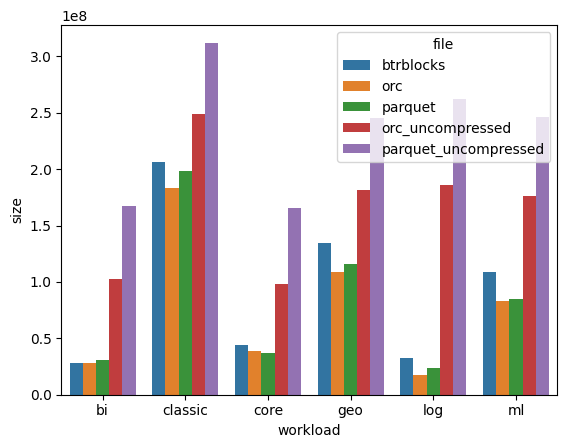

In [25]:
sns.barplot(data = data, x='workload', y='size', hue='file')

<Axes: xlabel='workload', ylabel='read_time'>

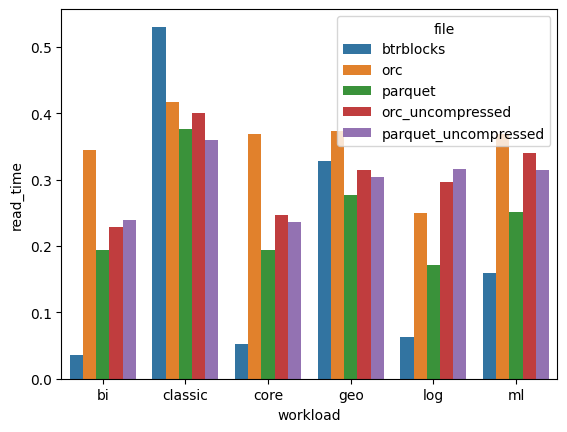

In [26]:
sns.barplot(data = data, x='workload', y='read_time', hue='file')

# Predefined workloads, filter (select)

In [ ]:
# generate filters and store in dir
os.chdir(dir_path)
for wl in workload_list:
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    filter_dir = f'{wl}_filters'
    os.makedirs(filter_dir, exist_ok=True)
    os.chdir(filter_dir)
    os.system(f'rm -rf point*.csv range*.csv')
    config_name = f'{PROJ_SRC_DIR}/benchmark/generator_v2/filter_config/{wl}_filter.yaml'
    os.system(f'''python3 {PROJ_SRC_DIR}/benchmark/generator_v2/filter_generator.py \
    ../{base_name}/gen_data/{base_name}.csv ../{base_name}/configs/table_config.json \
        {config_name}''')
    os.chdir(dir_path)

In [ ]:
# running experiments
import yaml
import itertools
os.system('rm outputs/stats.json')
output_stats = {}
for wl in workload_list:
    print(f'begin wl: {wl}')
    output_stats['wl'] = wl
    base_name = f'{wl}_r{num_rows}_c{num_cols}'
    filter_dir = f'{wl}_filters'
    config_name = f'{PROJ_SRC_DIR}/benchmark/generator_v2/filter_config/{wl}_filter.yaml'
    config = yaml.safe_load(open(config_name))
    config_list = config['filter_config']
    proj_type = 'one'
    for (i, fmt, config) in itertools.product(range(5), ['parquet', 'orc'], config_list):
        output_stats['format'] = fmt
        output_stats['i'] = i
        output_stats['proj_type'] = proj_type
        expectation = config.get('selectivity_expectation')
        output_stats['selectivity'] = expectation
        range_exist = True
        point_exist = True
        try:
            range_filters = pd.read_csv(f'{filter_dir}/range_{expectation}.csv')
        except:
            range_exist = False
        try:
            point_filters = pd.read_csv(f'{filter_dir}/point_{expectation}.csv')
        except:
            point_exist = False
        if range_exist:
            output_stats['filter_type'] = 'range'
            for index, row in range_filters.iterrows():
                val1 = np.int64(float(row['val1'])) if row['dtype'] == 'int' else row['val1']
                val2 = np.int64(float(row['val2'])) if row['dtype'] == 'int' else row['val2']
                os.system('sync; echo 3 > /proc/sys/vm/drop_caches')
                if fmt == 'parquet':
                    cmd = f"parquet-filterscan-noeval -f \
                        {base_name}.parquet -i {row['col_idx']} -l {val1} -r \
                            {val2} -e true"
                    output_stats['time'] = os.popen(cmd).read().split('\n')[0].split(' ')[-2]
                    output_stats['time_preload'] = os.popen(cmd).read().split('\n')[0].split(' ')[-2]
                else:
                    cmd = f"{HOME_DIR}/orc/build/c++/test/FilterExp \
                    {base_name}.orc f{row['col_idx']} {row['dtype']} range \
                        {val1} {val2} {proj_type} e"
                    output_stats['time'] = float(os.popen(cmd).read().split('\n')[0].split(' ')[-1])*1000
                    output_stats['time_preload'] = float(os.popen(cmd).read().split('\n')[0].split(' ')[-1])*1000
                parse_output(output_stats)
        if point_exist:
            output_stats['filter_type'] = 'point'
            for index, row in point_filters.iterrows():
                val1 = np.int64(float(row['value'])) if row['dtype'] == 'int' else row['value']
                val2 = np.int64(float(row['value'])) if row['dtype'] == 'int' else row['value']
                os.system('sync; echo 3 > /proc/sys/vm/drop_caches')
                if fmt == 'parquet':
                    cmd = f"parquet-filterscan-noeval -f \
                        {base_name}.parquet -i {row['col_idx']} -l {val1} -r \
                            {val2} -e true"
                    output_stats['time'] = os.popen(cmd).read().split('\n')[0].split(' ')[-2]
                    output_stats['time_preload'] = os.popen(cmd).read().split('\n')[0].split(' ')[-2]
                else:
                    cmd = f"{HOME_DIR}/orc/build/c++/test/FilterExp \
                    {base_name}.orc f{row['col_idx']} {row['dtype']} range \
                        {val1} {val2} {proj_type} e"
                    output_stats['time'] = float(os.popen(cmd).read().split('\n')[0].split(' ')[-1])*1000
                    output_stats['time_preload'] = float(os.popen(cmd).read().split('\n')[0].split(' ')[-1])*1000
                parse_output(output_stats)
collect_results()
os.system('mv outputs/stats.csv ../outputs/{}_{}.csv'.format(f'general_filter', timestamp))